In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [80]:
def clean_data(path):
    df = pd.read_csv(path)
    df.dropna(inplace=True)
    phone_df = pd.get_dummies(df['phone'])
    city_df = pd.get_dummies(df['city'])
    df['Astapor'] = city_df['Astapor']
    df["King's Landing"] = city_df["King's Landing"]
    df['Winterfell'] = city_df['Winterfell']
    df['Android'] = phone_df['Android']
    df['iPhone'] = phone_df['iPhone']
    df.drop('phone',axis=1,inplace=True)
    df.drop('city',axis=1,inplace=True)
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['day_of_week'] = df['signup_date'].apply(lambda x: x.dayofweek)
    df['signup_weekend'] = df['day_of_week'].apply(lambda x: x > 4)
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['churn'] = df['last_trip_date'].apply(lambda x: x < pd.to_datetime('2014-06-01')).astype(int)
    df['luxury_car_user'] = df['luxury_car_user']*1
    df['signup_weekend'] = df['signup_weekend']*1
    df['avg_total_rating'] = df['avg_rating_by_driver'] + df['avg_rating_of_driver']
    #df.drop(columns = ['Android', 'Astapor', 'last_trip_date', 'signup_date', 'day_of_week'],inplace=True)
    #df.drop(columns = ['iPhone', 'Winterfell'],inplace=True)
    return df

In [21]:
df = clean_data('ride-share/data/churn_train.csv')
df.shape

(33132, 19)

In [82]:
y = df['churn']
X=df[['trips_in_first_30_days','weekday_pct','luxury_car_user','Android','surge_pct']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:

    rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)
    rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [83]:
def rfc_model(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)
    rfc.fit(X_train, y_train)
    
    y_preds = rfc.predict(X_test)
    recall = recall_score(y_test, y_preds)
    score = rfc.score(X_train, y_train)
    oob = rfc.oob_score_
    
    return (f'recall = {recall}', f'Out of Bag = {oob}')

def rfc_feature_importance(X_train, y_train, X_test, y_test):
    
    rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)
    rfc.fit(X_train, y_train)
    
    #Feature Importance
    importances = rfc.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    print('------------------------------')
    print('Feature headers:')

    headers = list(X.columns.values)
    for idx, val in enumerate(headers):
        print(f'feature {idx}:', val)

    # Plot the feature importances of the forest
    plt.figure(figsize = (12,7))
    plt.title("Feature importances", size=24)
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), headers, rotation=45)
    plt.xlim([-1, X.shape[1]])
    plt.savefig('feature_importance.png')
    plt.show()

In [84]:
rfc_model(X_train, y_train, X_test, y_test)

('recall = 0.850440642820114', 'Out of Bag = 0.7478211658177703')

Feature ranking:
1. feature 1 (0.407189)
2. feature 4 (0.283940)
3. feature 0 (0.118516)
4. feature 3 (0.102424)
5. feature 2 (0.087931)
------------------------------
Feature headers:
feature 0: trips_in_first_30_days
feature 1: weekday_pct
feature 2: luxury_car_user
feature 3: Android
feature 4: surge_pct


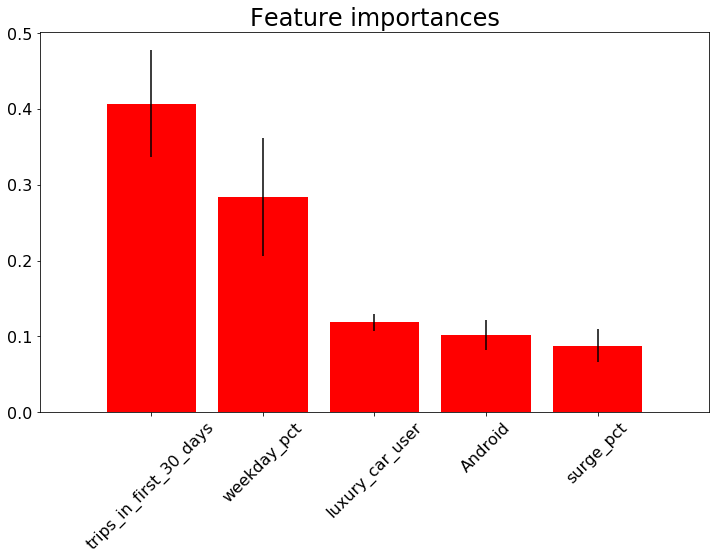

In [85]:
rfc_feature_importance(X_train, y_train, X_test, y_test)

In [86]:
#('recall = 0.8462934162778641', 'Out of Bag = 0.7661573288058857')

In [91]:
df2 = clean_data('ride-share/data/churn_test.csv')
y2 = df2['churn']
X2 = df2[['trips_in_first_30_days','weekday_pct','luxury_car_user','Android','surge_pct']]
y_final_preds = rfc.predict(X2)
final_recall = recall_score(y2, y_final_preds)
final_recall

0.8468948555031769

In [22]:
df2.shape

(8313, 19)

In [95]:
def decision_tree(X_train,y_train,X_test,y_test):
    model = tree.DecisionTreeClassifier(max_depth=5)
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    return model,y_hat

In [96]:
model, y_hat = decision_tree(X_train, y_train, X_test, y_test)

[Text(2678.4, 1174.1760000000002, 'X[4] <= 0.25\ngini = 0.483\nsamples = 26505\nvalue = [10832, 15673]'),
 Text(1339.2, 913.248, 'X[3] <= 0.5\ngini = 0.425\nsamples = 17189\nvalue = [5258, 11931]'),
 Text(669.6, 652.3200000000002, 'X[2] <= 0.5\ngini = 0.465\nsamples = 11632\nvalue = [4285, 7347]'),
 Text(334.8, 391.39200000000005, 'X[1] <= 99.1\ngini = 0.416\nsamples = 7103\nvalue = [2094, 5009]'),
 Text(167.4, 130.46400000000017, 'gini = 0.46\nsamples = 4279\nvalue = [1532, 2747]'),
 Text(502.20000000000005, 130.46400000000017, 'gini = 0.319\nsamples = 2824\nvalue = [562, 2262]'),
 Text(1004.4000000000001, 391.39200000000005, 'X[1] <= 3.85\ngini = 0.499\nsamples = 4529\nvalue = [2191, 2338]'),
 Text(837.0, 130.46400000000017, 'gini = 0.365\nsamples = 634\nvalue = [152, 482]'),
 Text(1171.8, 130.46400000000017, 'gini = 0.499\nsamples = 3895\nvalue = [2039, 1856]'),
 Text(2008.8000000000002, 652.3200000000002, 'X[1] <= 98.9\ngini = 0.289\nsamples = 5557\nvalue = [973, 4584]'),
 Text(167

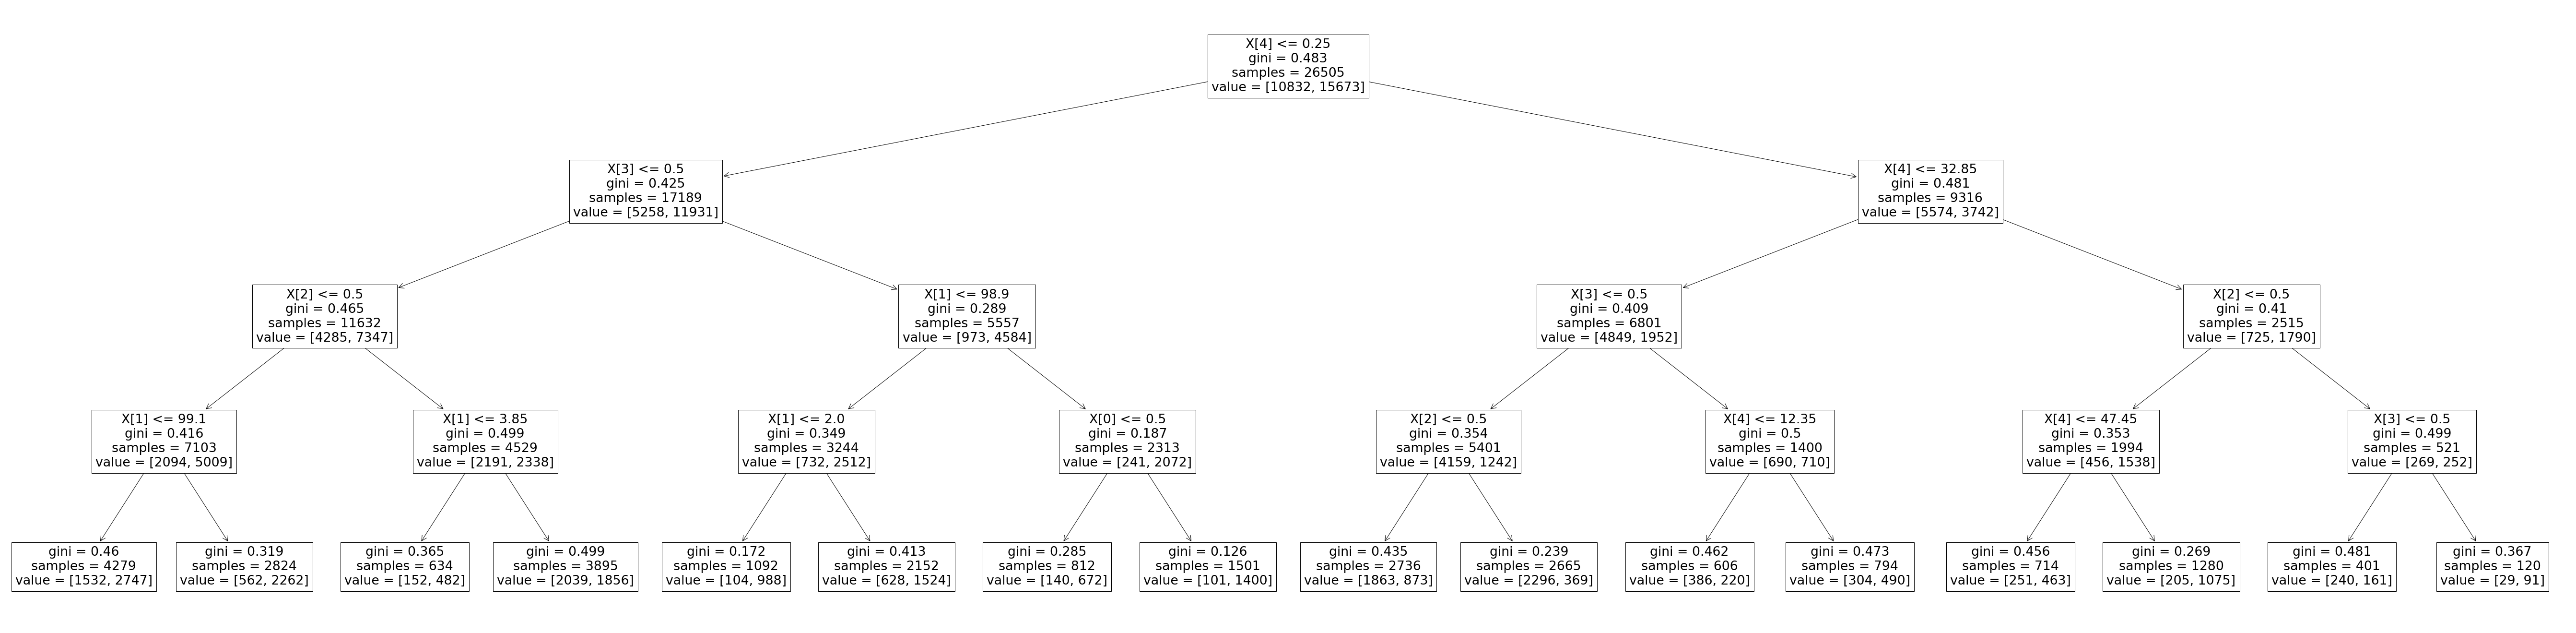

In [16]:
plt.figure(figsize=(96,24))
tree.plot_tree(model) 

In [18]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_recall = recall_score(y_test, lr_preds)
lr_recall

/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7830482115085536

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
lr1 = LogisticRegression(random_state=0).fit(scaler.transform(X_train),y_train)
y_scale_preds = lr1.predict(scaler.transform(X_test))
lr_recall = recall_score(y_test, y_scale_preds)
lr_recall

/home/alec/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.782789009849663